In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import itertools
import argparse
import re
import os
import pickle
from sklearn.preprocessing import StandardScaler

In [3]:
# Let's use AMZN (Amazon), AAPL (Apple), GOOG (Google), MSFT (Microsoft)
def get_data(choice):
    # currently only for amazon and apple
    # returns in the format listt of [(stock1, stock2)], [(senti1, senti2)], [(trend1, trend2))]
    # each row is a different stock
    # 0 = AMZN
    # 1 = APPL
    # 2 = GOOG
    # 3 = MSFT 
    choice_map = {1: 'Amazon',
                  2: 'Apple',
                  3: 'Google',
                  4: 'Microsoft',
                  5: 'All'}
    choice = choice.split()
    data = pd.read_csv('Combined_data.csv')
    stock_list, trend_list, senti_list = [], [], []
    for ch in choice:
        curr_comp = choice_map[int(ch)]
        stock_list.append(data[curr_comp+'_Adj Close'])
        trend_list.append(data[curr_comp+'_Target_Direction'])
        senti_list.append(data[curr_comp+'_sentiment'])
    stock_data = list(zip(*stock_list))
    senti_data = list(zip(*senti_list))
    trend_data = list(zip(*trend_list))
#     result = list(zip(stock_data, senti_data, trend_data))
    return np.array(stock_data), np.array(senti_data), np.array(trend_data)

def get_scaler(env):
  # return scikit-learn scaler object to scale the states
  # Note: you could also populate the replay buffer here
    states = []
    for _ in range(env.n_step):
        action = np.random.choice(env.action_space)
        state, reward, done, info = env.step(action)
        states.append(state)
        if done:
            break
    scaler = StandardScaler()
    scaler.fit(states)
    return scaler


def maybe_make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
        


In [4]:
class LinearModel:
    """ A linear regression model """
    def __init__(self, input_dim, n_action):
        self.W = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
        self.b = np.zeros(n_action)

        # momentum terms
        self.vW = 0
        self.vb = 0

        self.losses = []

    def predict(self, X):
        # make sure X is N x D
        assert(len(X.shape) == 2)
        return X.dot(self.W) + self.b

    def sgd(self, X, Y, learning_rate=0.01, momentum=0.9):
        # make sure X is N x D
        assert(len(X.shape) == 2)

        # the loss values are 2-D
        # normally we would divide by N only
        # but now we divide by N x K
        num_values = np.prod(Y.shape)

        # do one step of gradient descent
        # we multiply by 2 to get the exact gradient
        # (not adjusting the learning rate)
        # i.e. d/dx (x^2) --> 2x
        Yhat = self.predict(X)
        gW = 2 * X.T.dot(Yhat - Y) / num_values
        gb = 2 * (Yhat - Y).sum(axis=0) / num_values

        # update momentum terms
        self.vW = momentum * self.vW - learning_rate * gW
        self.vb = momentum * self.vb - learning_rate * gb

        # update params
        self.W += self.vW
        self.b += self.vb

        mse = np.mean((Yhat - Y)**2)
        self.losses.append(mse)
        
    def load_weights(self, filepath):
        npz = np.load(filepath)
        self.W = npz['W']
        self.b = npz['b']

    def save_weights(self, filepath):
        np.savez(filepath, W=self.W, b=self.b)


In [5]:
class MultiStockEnv:
    """
    A 3-stock trading environment.
    State: vector of size 7 (n_stock * 2 + 1)
    - # shares of stock 1 owned
    - # shares of stock 2 owned
    - # shares of stock 3 owned
    - price of stock 1 (using daily close price)
    - price of stock 2
    - price of stock 3
    - cash owned (can be used to purchase more stocks)
    Action: categorical variable with 27 (3^3) possibilities
    - for each stock, you can:
    - 0 = sell
    - 1 = hold
    - 2 = buy
    """
    def __init__(self, stock_data, senti_data, trend_data, initial_investment=20000):
        # data
        self.stock_price_history = stock_data
        self.senti_history = senti_data
        self.trend_history = trend_data
        self.n_step, self.n_stock = self.stock_price_history.shape

        # instance attributes
        self.initial_investment = initial_investment
        self.cur_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None
        self.trend = None
        self.senti = None

        self.action_space = np.arange(3**self.n_stock)

        # action permutations
        # returns a nested list with elements like:
        # [0,0,0]
        # [0,0,1]
        # [0,0,2]
        # [0,1,0]
        # [0,1,1]
        # etc.
        # 0 = sell
        # 1 = hold
        # 2 = buy
        self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

        # calculate size of state
        # number of stock owned, stock price, sentiment, trend, cash in hand
        self.state_dim = self.n_stock * 4 + 1

        self.reset()


    def reset(self):
        self.cur_step = 0
        self.stock_owned = np.zeros(self.n_stock)
        self.stock_price = self.stock_price_history[self.cur_step]
        self.senti = self.senti_history[self.cur_step]
        self.trend = self.trend_history[self.cur_step]
        self.cash_in_hand = self.initial_investment
        return self._get_obs()


    def step(self, action):
        assert action in self.action_space

        # get current value before performing the action
        prev_val = self._get_val()

        # update price, i.e. go to the next day
        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]
        self.senti = self.senti_history[self.cur_step]
        self.trend = self.trend_history[self.cur_step]

        # perform the trade
        self._trade(action)

        # get the new value after taking the action
        cur_val = self._get_val()

        # reward is the increase in porfolio value
        reward = cur_val - prev_val

        # done if we have run out of data
        done = self.cur_step == self.n_step - 1

        # store the current value of the portfolio here
        info = {'cur_val': cur_val}

        # conform to the Gym API
        return self._get_obs(), reward, done, info


    def _get_obs(self):
    #
        obs = np.empty(self.state_dim)
        obs[:self.n_stock] = self.stock_owned
        obs[self.n_stock:2*self.n_stock] = self.stock_price
        obs[2*self.n_stock:3*self.n_stock] = self.senti
        obs[3*self.n_stock:4*self.n_stock] = self.trend
        obs[-1] = self.cash_in_hand
        return obs



    def _get_val(self):
        return self.stock_owned.dot(self.stock_price) + self.cash_in_hand


    def _trade(self, action):
        # index the action we want to perform
        # 0 = sell
        # 1 = hold
        # 2 = buy
        # e.g. [2,1,0] means:
        # buy first stock
        # hold second stock
        # sell third stock
        action_vec = self.action_list[action]

        # determine which stocks to buy or sell
        sell_index = [] # stores index of stocks we want to sell
        buy_index = [] # stores index of stocks we want to buy
        for i, a in enumerate(action_vec):
            if a == 0:
                sell_index.append(i)
            elif a == 2:
                buy_index.append(i)

        # sell any stocks we want to sell
        # then buy any stocks we want to buy
        if sell_index:
          # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock
          for i in sell_index:
            self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
            self.stock_owned[i] = 0
        if buy_index:
          # NOTE: when buying, we will loop through each stock we want to buy,
          #       and buy one share at a time until we run out of cash
                can_buy = True
                while can_buy:
                    for i in buy_index:
                        if self.cash_in_hand > self.stock_price[i]:
                            self.stock_owned[i] += 1 # buy one share
                            self.cash_in_hand -= self.stock_price[i]
                        else:
                            can_buy = False


In [6]:
class DQNAgent(object):
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0 # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = LinearModel(state_size, action_size)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
              return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action


    def train(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(self.model.predict(next_state), axis=1)

        target_full = self.model.predict(state)
        target_full[0, action] = target

        # Run one training step
        self.model.sgd(state, target_full)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    def load(self, name):
        self.model.load_weights(name)


    def save(self, name):
        self.model.save_weights(name)


In [7]:
def play_one_episode(agent, env, is_train, scaler):
  # note: after transforming states are already 1xD
    state = env.reset()
    state = scaler.transform([state])
    done = False

    while not done:
        action = agent.act(state) # get action
        next_state, reward, done, info = env.step(action) # get the next state, reward etc 
        next_state = scaler.transform([next_state])
        if is_train == 'train':
            agent.train(state, action, reward, next_state, done)
        state = next_state

    return info['cur_val']

In [11]:
def train_test():
    
    choice_map = {1: 'Amazon',
                  2: 'Apple',
                  3: 'Google',
                  4: 'Microsoft',
                  5: 'All'}

    # config
    models_folder = 'linear_rl_trader_models'
    rewards_folder = 'linear_rl_trader_rewards'
    num_episodes = 20
    batch_size = 32
    threshold_investment = 10000
    initial_investment = 20000
    maybe_make_dir(models_folder)
    maybe_make_dir(rewards_folder)
    
    print('Enter your choice of companies in space sperated numbers')
    print('1 - Amazon')
    print('2 - Apple')
    print('3 - Google')
    print('4 - Microsoft')

    # taking inout from the user 
    choices = [] # to store list of selected companies
    exit = False
    choices = input()

#     print('Enter your initial investment')
#     while True:
#         initial_investment = int(input())
#         if initial_investment < threshold_investment:
#             print('Enter investment greater than Rupees 10000')
#         else:
#             break    

    stock_data, senti_data, trend_data = get_data(choices)
    n_timesteps = len(stock_data)
    n_stocks = len(stock_data[0])

    n_train = 1008 #stock data till 2016

    train_stock_data = stock_data[:n_train]
    train_senti_data = senti_data[:n_train]
    train_trend_data = trend_data[:n_train]
    test_stock_data = stock_data[n_train:]
    test_senti_data = senti_data[n_train:]
    test_trend_data = trend_data[n_train:]
    env = MultiStockEnv(train_stock_data, train_senti_data, train_trend_data, initial_investment)
    state_size = env.state_dim
    action_size = len(env.action_space)
    agent = DQNAgent(state_size, action_size)
    scaler = get_scaler(env)

    # store the final value of the portfolio (end of episode)
    train_portfolio_value = []
    
    print("-------------------In Training Phase----------------------------------------------------")
    # repeat the experiemnt num_episodes times
    print('please wait we are training on the your choice of companies')
    for e in range(num_episodes):
        t0 = datetime.now()
        val = play_one_episode(agent, env, 'train', scaler)
        dt = datetime.now() - t0
        print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
        train_portfolio_value.append(val) # append episode end portfolio value
    
    agent.save(f'{models_folder}/linear.npz')

    # save the scaler
    with open(f'{models_folder}/scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    # plot losses
    print('The loss in training phase')
    plt.plot(agent.model.losses)
    plt.show()
    
    average = sum(train_portfolio_value)/len(train_portfolio_value)
    avg_return = average/initial_investment
    min_return = min(train_portfolio_value)/initial_investment
    max_return = max(train_portfolio_value)/initial_investment
    print(f"After training for {num_episodes} episodes and an intial investment of {initial_investment}:")
    print(f"Average total return amount: {average:.2f}")
    print(f"Average returns on total investment: {avg_return:.2f}")
    print(f"Minimum returns on total investment: {min_return:.2f}")
    print(f"Maximum returns on total investment: {max_return:.2f}")
    np.save(f'{rewards_folder}/{"train"}.npy', train_portfolio_value)
    
    print("-----------------In Testing Phase-------------------------------------------------------")
    print('please wait we are testing on the your choice of companies')
    with open(f'{models_folder}/scaler.pkl', 'rb') as f:
              scaler = pickle.load(f)

    # remake the env with test data
    env = MultiStockEnv(test_stock_data, test_senti_data, test_trend_data, initial_investment)

    # make sure epsilon is not 1!
    # no need to run multiple episodes if epsilon = 0, it's deterministic
    agent.epsilon = 0.01 # exploration in testing phase

    # load trained weights
    agent.load(f'{models_folder}/linear.npz')
    
    test_portfolio_value = []
    # repeat the experiemnt num_episodes times
    for e in range(num_episodes):
        t0 = datetime.now()
        val = play_one_episode(agent, env, 'test', scaler)
        dt = datetime.now() - t0
        print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
        test_portfolio_value.append(val) # append episode end portfolio value
        

    average = sum(test_portfolio_value)/len(test_portfolio_value)
    avg_return = average/initial_investment
    min_return = min(test_portfolio_value)/initial_investment
    max_return = max(test_portfolio_value)/initial_investment
    print(f"After testing for {num_episodes} episodes and an intial investment of {initial_investment}:")
    print(f"Average total return amount: {average:.2f}")
    print(f"Average returns on total investment: {avg_return:.2f}")
    print(f"Minimum returns on total investment: {min_return:.2f}")
    print(f"Maximum returns on total investment: {max_return:.2f}")
    np.save(f'{rewards_folder}/{"test"}.npy', test_portfolio_value)
    print()
    print()
    print('Returns in training phase')
    plt.plot(train_portfolio_value)
    plt.show()
    print()
    print('Returns in testing phase')
    plt.plot(test_portfolio_value)
    plt.show()
    

Enter your choice of companies in space sperated numbers
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
1
Enter your initial investment
20000
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
episode: 1/20, episode end value: 41507.16, duration: 0:00:29.332355
episode: 2/20, episode end value: 45865.72, duration: 0:01:19.352963
episode: 3/20, episode end value: 67187.47, duration: 0:01:01.922028
episode: 4/20, episode end value: 64278.92, duration: 0:01:48.876665
episode: 5/20, episode end value: 82714.49, duration: 0:01:14.977646
episode: 6/20, episode end value: 62497.35, duration: 0:00:30.876046
episode: 7/20, episode end value: 42096.44, duration: 0:00:51.954153
episode: 8/20, episode end value: 74814.47, duration: 0:01:52.092366
episode: 9/20, episode end value: 67687.39, duration: 0:00:55.432060
episode: 10/20, episode end value: 116023.54, duration: 0:02:33.106617
episode: 11/20, ep

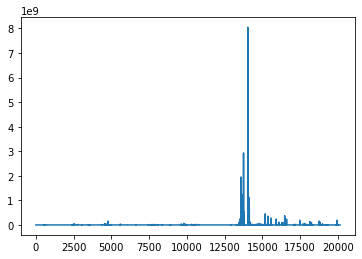

After training for 20 episodes and an intial investment of 20000:
Average total return amount: 62609.96
Average returns on total investment: 3.13
Minimum returns on total investment: 1.05
Maximum returns on total investment: 5.86
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
episode: 1/20, episode end value: 30873.43, duration: 0:00:00.583031
episode: 2/20, episode end value: 30127.66, duration: 0:00:00.183040
episode: 3/20, episode end value: 13564.05, duration: 0:00:00.280993
episode: 4/20, episode end value: 30237.31, duration: 0:00:00.268778
episode: 5/20, episode end value: 30262.27, duration: 0:00:00.313696
episode: 6/20, episode end value: 26995.92, duration: 0:00:00.429650
episode: 7/20, episode end value: 30918.77, duration: 0:00:00.499063
episode: 8/20, episode end value: 29699.45, duration: 0:00:00.410506
episode: 9/20, episode end value: 30026.02, duration: 0:00:00.251682
e

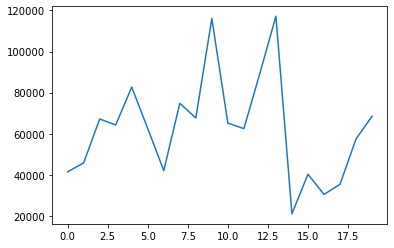


Returns in testing phase


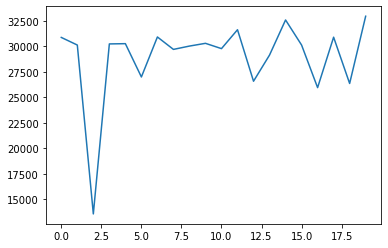

In [13]:
# Amazon
train_test()

Enter your choice of companies in space sperated numbers
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
2
Enter your initial investment
20000
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
episode: 1/20, episode end value: 26251.21, duration: 0:00:19.709457
episode: 2/20, episode end value: 13381.25, duration: 0:00:17.466680
episode: 3/20, episode end value: 17393.05, duration: 0:00:09.814883
episode: 4/20, episode end value: 43779.33, duration: 0:00:55.424130
episode: 5/20, episode end value: 29764.70, duration: 0:00:04.697376
episode: 6/20, episode end value: 7463.21, duration: 0:00:15.048059
episode: 7/20, episode end value: 53876.75, duration: 0:00:49.784362
episode: 8/20, episode end value: 32645.68, duration: 0:00:29.137533
episode: 9/20, episode end value: 56833.25, duration: 0:00:55.055188
episode: 10/20, episode end value: 18887.99, duration: 0:00:12.455345
episode: 11/20, epis

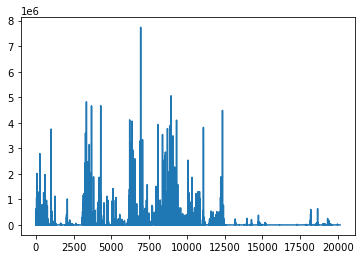

After training for 20 episodes and an intial investment of 20000:
Average total return amount: 25259.92
Average returns on total investment: 1.26
Minimum returns on total investment: 0.37
Maximum returns on total investment: 2.84
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
episode: 1/20, episode end value: 20340.60, duration: 0:00:00.270208
episode: 2/20, episode end value: 18853.25, duration: 0:00:00.118898
episode: 3/20, episode end value: 19710.41, duration: 0:00:00.151946
episode: 4/20, episode end value: 19871.22, duration: 0:00:00.312474
episode: 5/20, episode end value: 21535.81, duration: 0:00:00.151833
episode: 6/20, episode end value: 20057.52, duration: 0:00:00.138178
episode: 7/20, episode end value: 19765.18, duration: 0:00:00.122279
episode: 8/20, episode end value: 20559.03, duration: 0:00:00.223331
episode: 9/20, episode end value: 19144.59, duration: 0:00:00.197343
e

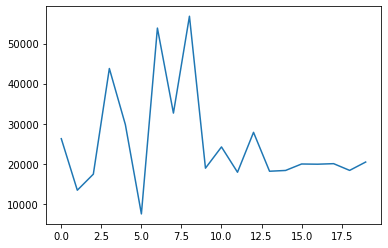


Returns in testing phase


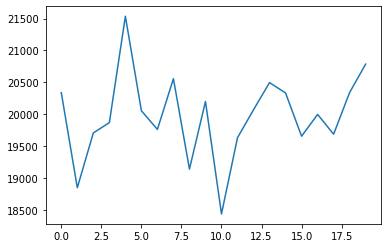

In [9]:
# Apple
train_test()

Enter your choice of companies in space sperated numbers
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
3
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
episode: 1/20, episode end value: 51334.11, duration: 0:00:25.574163
episode: 2/20, episode end value: 17652.72, duration: 0:00:14.027327
episode: 3/20, episode end value: 29568.95, duration: 0:00:27.784159
episode: 4/20, episode end value: 52533.34, duration: 0:00:29.995051
episode: 5/20, episode end value: 20000.00, duration: 0:00:00.151629
episode: 6/20, episode end value: 49393.66, duration: 0:00:27.208686
episode: 7/20, episode end value: 53031.81, duration: 0:00:47.620280
episode: 8/20, episode end value: 34781.86, duration: 0:00:26.465802
episode: 9/20, episode end value: 33899.25, duration: 0:00:15.237467
episode: 10/20, episode end value: 26876.91, duration: 0:00:11.237907
episode: 11/20, episode end value: 30499.84, duration: 

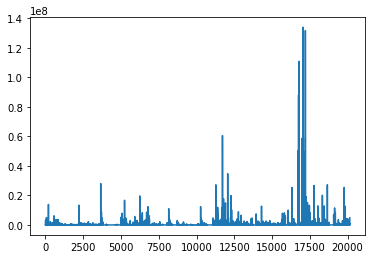

After training for 20 episodes and an intial investment of 20000:
Average total return amount: 45676.64
Average returns on total investment: 2.28
Minimum returns on total investment: 0.88
Maximum returns on total investment: 4.16
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
episode: 1/20, episode end value: 28502.10, duration: 0:00:00.234626
episode: 2/20, episode end value: 27771.85, duration: 0:00:00.196647
episode: 3/20, episode end value: 30970.23, duration: 0:00:00.235966
episode: 4/20, episode end value: 28715.79, duration: 0:00:00.249723
episode: 5/20, episode end value: 28938.14, duration: 0:00:00.316317
episode: 6/20, episode end value: 28593.84, duration: 0:00:00.153196
episode: 7/20, episode end value: 30413.85, duration: 0:00:00.261430
episode: 8/20, episode end value: 28184.88, duration: 0:00:00.197846
episode: 9/20, episode end value: 28099.37, duration: 0:00:00.217233
e

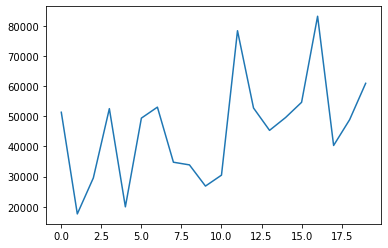


Returns in testing phase


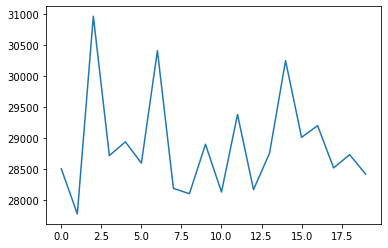

In [12]:
# Google
train_test()

Enter your choice of companies in space sperated numbers
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
4
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
episode: 1/20, episode end value: 87247.91, duration: 0:01:52.101947
episode: 2/20, episode end value: 92768.07, duration: 0:02:07.090930
episode: 3/20, episode end value: 59021.90, duration: 0:01:02.998439
episode: 4/20, episode end value: 27469.36, duration: 0:00:33.990295
episode: 5/20, episode end value: 59694.58, duration: 0:01:43.048438
episode: 6/20, episode end value: 103363.10, duration: 0:02:04.182186
episode: 7/20, episode end value: 43491.17, duration: 0:02:26.529502
episode: 8/20, episode end value: 46228.02, duration: 0:00:45.728106
episode: 9/20, episode end value: 80215.18, duration: 0:05:57.985979
episode: 10/20, episode end value: 8162.68, duration: 0:00:21.870327
episode: 11/20, episode end value: 16396.16, duration: 

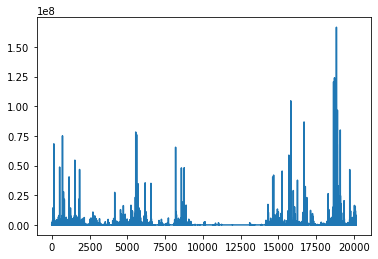

After training for 20 episodes and an intial investment of 20000:
Average total return amount: 63771.65
Average returns on total investment: 3.19
Minimum returns on total investment: 0.41
Maximum returns on total investment: 7.27
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
episode: 1/20, episode end value: 48196.28, duration: 0:00:05.443745
episode: 2/20, episode end value: 47970.02, duration: 0:00:05.098211
episode: 3/20, episode end value: 47391.39, duration: 0:00:04.932456
episode: 4/20, episode end value: 47811.90, duration: 0:00:04.997563
episode: 5/20, episode end value: 47432.10, duration: 0:00:05.372300
episode: 6/20, episode end value: 48889.09, duration: 0:00:05.654132
episode: 7/20, episode end value: 49411.38, duration: 0:00:05.819948
episode: 8/20, episode end value: 48181.17, duration: 0:00:05.463626
episode: 9/20, episode end value: 45232.56, duration: 0:00:05.458598
e

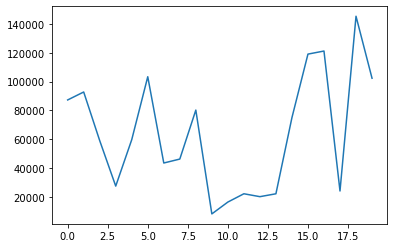


Returns in testing phase


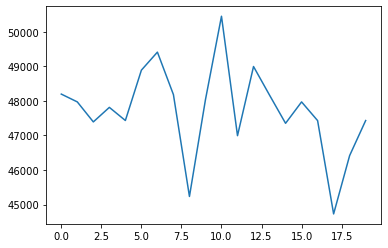

In [13]:
# Microsoft
train_test() 

Enter your choice of companies in space sperated numbers
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
2 3 4
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
episode: 1/20, episode end value: 149369.37, duration: 0:04:15.127446
episode: 2/20, episode end value: 120923.74, duration: 0:02:09.454683
episode: 3/20, episode end value: 92406.31, duration: 0:03:51.549289
episode: 4/20, episode end value: 46943.05, duration: 0:01:07.637611
episode: 5/20, episode end value: 65943.85, duration: 0:01:09.214680
episode: 6/20, episode end value: 51709.17, duration: 0:02:48.758795
episode: 7/20, episode end value: 11943.82, duration: 0:00:40.024483
episode: 8/20, episode end value: 21457.00, duration: 0:00:51.206892
episode: 9/20, episode end value: 35959.24, duration: 0:00:21.041066
episode: 10/20, episode end value: 147930.93, duration: 0:00:16.542209
episode: 11/20, episode end value: 141569.74, du

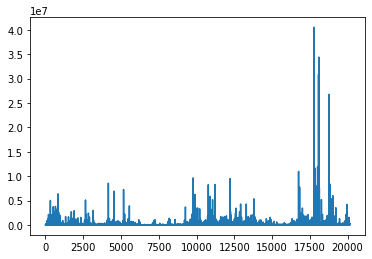

After training for 20 episodes and an intial investment of 20000:
Average total return amount: 93499.56
Average returns on total investment: 4.67
Minimum returns on total investment: 0.60
Maximum returns on total investment: 9.78
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
episode: 1/20, episode end value: 23825.85, duration: 0:00:00.920453
episode: 2/20, episode end value: 22723.04, duration: 0:00:00.989277
episode: 3/20, episode end value: 21905.42, duration: 0:00:00.690618
episode: 4/20, episode end value: 22060.29, duration: 0:00:00.727219
episode: 5/20, episode end value: 22015.50, duration: 0:00:00.825107
episode: 6/20, episode end value: 23726.48, duration: 0:00:00.875931
episode: 7/20, episode end value: 22617.22, duration: 0:00:00.793546
episode: 8/20, episode end value: 21304.41, duration: 0:00:00.644416
episode: 9/20, episode end value: 18855.01, duration: 0:00:00.948228
e

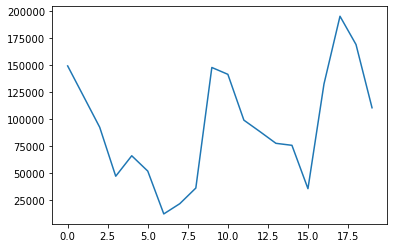


Returns in testing phase


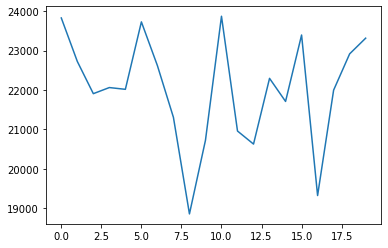

In [14]:
#Apple Google Microsoft 
train_test()


Enter your choice of companies in space sperated numbers
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
1 3 4
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
episode: 1/20, episode end value: 183174.70, duration: 0:01:10.199213
episode: 2/20, episode end value: 163877.57, duration: 0:00:06.744857
episode: 3/20, episode end value: 110562.84, duration: 0:00:13.405626
episode: 4/20, episode end value: 147164.60, duration: 0:00:06.516046
episode: 5/20, episode end value: 227207.75, duration: 0:00:10.127453
episode: 6/20, episode end value: 109857.49, duration: 0:00:14.321376
episode: 7/20, episode end value: 177455.99, duration: 0:00:10.871706
episode: 8/20, episode end value: 149139.07, duration: 0:00:12.645557
episode: 9/20, episode end value: 128513.09, duration: 0:00:22.041999
episode: 10/20, episode end value: 137445.25, duration: 0:00:26.862494
episode: 11/20, episode end value: 207011

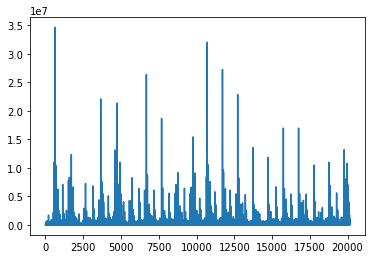

After training for 20 episodes and an intial investment of 20000:
Average total return amount: 162116.98
Average returns on total investment: 8.11
Minimum returns on total investment: 5.49
Maximum returns on total investment: 11.36
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
episode: 1/20, episode end value: 37689.10, duration: 0:00:01.119532
episode: 2/20, episode end value: 37847.17, duration: 0:00:01.021934
episode: 3/20, episode end value: 36734.49, duration: 0:00:01.371740
episode: 4/20, episode end value: 40226.66, duration: 0:00:01.442657
episode: 5/20, episode end value: 39852.80, duration: 0:00:01.151515
episode: 6/20, episode end value: 37956.15, duration: 0:00:01.268694
episode: 7/20, episode end value: 35075.33, duration: 0:00:01.275935
episode: 8/20, episode end value: 36665.49, duration: 0:00:01.661519
episode: 9/20, episode end value: 37996.42, duration: 0:00:01.326860

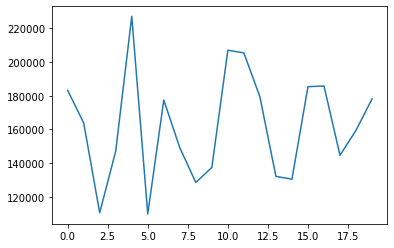


Returns in testing phase


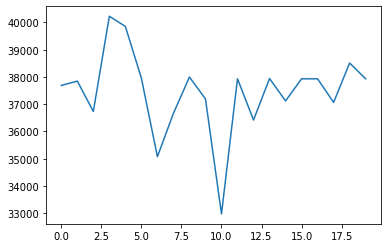

In [15]:
#Amazon Google Microsoft
train_test()

Enter your choice of companies in space sperated numbers
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
1 2 3
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
episode: 1/20, episode end value: 64158.07, duration: 0:00:29.741163
episode: 2/20, episode end value: 90800.04, duration: 0:00:15.162905
episode: 3/20, episode end value: 43314.36, duration: 0:00:17.185111
episode: 4/20, episode end value: 119194.85, duration: 0:02:05.620811
episode: 5/20, episode end value: 80077.18, duration: 0:00:55.083487
episode: 6/20, episode end value: 46649.55, duration: 0:00:32.868286
episode: 7/20, episode end value: 130983.15, duration: 0:02:15.297353
episode: 8/20, episode end value: 37954.63, duration: 0:03:29.720060
episode: 9/20, episode end value: 89385.09, duration: 0:00:44.711338
episode: 10/20, episode end value: 157928.77, duration: 0:00:26.216218
episode: 11/20, episode end value: 86935.54, dur

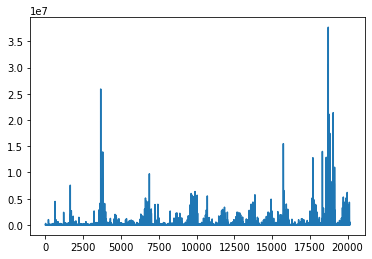

After training for 20 episodes and an intial investment of 20000:
Average total return amount: 108157.41
Average returns on total investment: 5.41
Minimum returns on total investment: 1.90
Maximum returns on total investment: 11.55
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
episode: 1/20, episode end value: 26312.74, duration: 0:00:02.526049
episode: 2/20, episode end value: 27869.85, duration: 0:00:03.031624
episode: 3/20, episode end value: 24117.32, duration: 0:00:03.112830
episode: 4/20, episode end value: 28726.76, duration: 0:00:04.219273
episode: 5/20, episode end value: 28392.84, duration: 0:00:02.831604
episode: 6/20, episode end value: 29291.37, duration: 0:00:02.942418
episode: 7/20, episode end value: 24320.83, duration: 0:00:02.913928
episode: 8/20, episode end value: 27790.28, duration: 0:00:02.521558
episode: 9/20, episode end value: 26369.04, duration: 0:00:03.046370

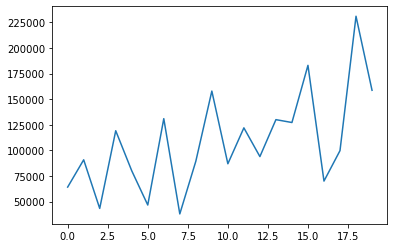


Returns in testing phase


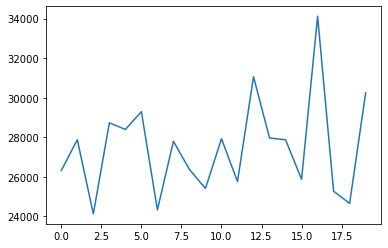

In [16]:
#Amazon Apple Google
train_test()

Enter your choice of companies in space sperated numbers
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
1 3 4
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
episode: 1/20, episode end value: 158768.30, duration: 0:02:22.681033
episode: 2/20, episode end value: 183863.92, duration: 0:00:11.708710
episode: 3/20, episode end value: 130793.94, duration: 0:00:07.451974
episode: 4/20, episode end value: 135960.05, duration: 0:00:10.098570
episode: 5/20, episode end value: 146788.50, duration: 0:00:11.635582
episode: 6/20, episode end value: 132901.76, duration: 0:00:29.093805
episode: 7/20, episode end value: 205474.14, duration: 0:00:06.649204
episode: 8/20, episode end value: 131672.70, duration: 0:00:30.182131
episode: 9/20, episode end value: 133024.71, duration: 0:00:12.806999
episode: 10/20, episode end value: 186165.06, duration: 0:00:21.029359
episode: 11/20, episode end value: 187813

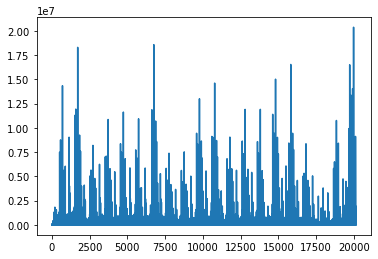

After training for 20 episodes and an intial investment of 20000:
Average total return amount: 164855.91
Average returns on total investment: 8.24
Minimum returns on total investment: 5.23
Maximum returns on total investment: 12.65
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
episode: 1/20, episode end value: 22966.05, duration: 0:00:00.451065
episode: 2/20, episode end value: 38435.17, duration: 0:00:00.535279
episode: 3/20, episode end value: 29214.31, duration: 0:00:00.191705
episode: 4/20, episode end value: 29220.07, duration: 0:00:00.984799
episode: 5/20, episode end value: 18777.79, duration: 0:00:00.647301
episode: 6/20, episode end value: 21668.77, duration: 0:00:00.293775
episode: 7/20, episode end value: 44001.60, duration: 0:00:00.337223
episode: 8/20, episode end value: 21024.44, duration: 0:00:00.883106
episode: 9/20, episode end value: 45132.48, duration: 0:00:00.694266

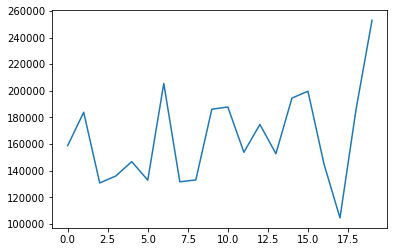


Returns in testing phase


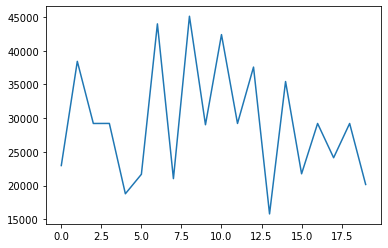

In [17]:
#Amazon Google Microsoft
train_test()